In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # you may use this if you decide to do some fitting 
plt.rcParams.update({'font.size': 20})



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Franck Hertz starter
For this experiment, you will be obtaining data from an oscilloscope.  The files output from the oscilloscope will be very similar the one below (called scope_55.csv).  Each file will be a different run you took on the scope, and you need to keep track of which file corresponds to which temperatures/voltages/ other parameters you varied.


In [3]:

example_scope = np.genfromtxt('/content/drive/MyDrive/Starter Notebooks for 315 labs/Franck Hertz/scope_55.csv',dtype=float,delimiter=',',skip_header=2)  # note: the path you input here depends on where you put your files in your Drive

time = example_scope[:,0]
channel1 = example_scope[:,1]
channel2 = example_scope[:,2]


Let's plot the data. Note there were three columns, which I split up into different arrays above (time, channel1, and channel2).

Notice how one column was time?  That's due to how the oscilloscope measurement is being done. What is happening is that the oscilloscope is supplying an accelerating voltage that is changing in time, and then measuring the resulting current at the anode (note that this current is actually measured and reported as a voltage using some internal resistance).

The applied voltage vs time is being output on Channel 1 of the oscilloscope, and the measured signal is on Channel 2.

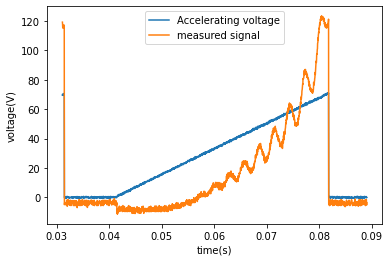

In [4]:
plt.plot(time, channel1)
plt.plot(time, channel2*100)  # just multiplied it by 100 so it is seen clearly on the graph when compared to channel1
plt.xlabel('time(s)')
plt.ylabel('voltage(V)')
plt.legend(['Accelerating voltage','measured signal'])



Since we are intersted in the response to the applied voltage, **now we should plot the measured signal vs the applied voltage.** i.e. plot channel 2 vs channel 1.

Text(0.5, 1.0, '"current" vs. accelerating voltage')

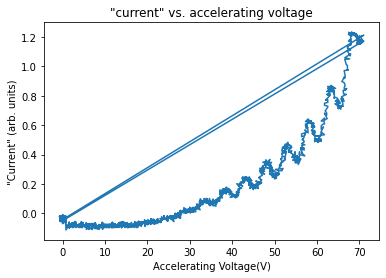

In [5]:
plt.plot(channel1, channel2)
# plt.xlim([40,50])
# plt.ylim([0,0.4])
plt.xlabel('Accelerating Voltage(V)')
plt.ylabel('"Current" (arb. units)')
plt.title('"current" vs. accelerating voltage')

But that looks kinda weird, doesn't it? If you zoom in on it (you can uncomment the `plt.xlim` and `plt.ylim` commands) you'll see that the lines connecting data points are going backwards as well sometimes.  This is because the accelerating voltage is not a perfectly incerasing quantitiy; there is some noise on channel 1.  To fix this plotting issue (which would also become a fitting issue if you decide to do any fits), let's just sort the signals so that the voltage is purely increasing.


Below, we sort channel1 using `np.argsort`.  This function returns the indices which would sort the array.  We then use those indices to re-order channel1 and channel2.


Text(0.5, 1.0, 'plotting the sorted values')

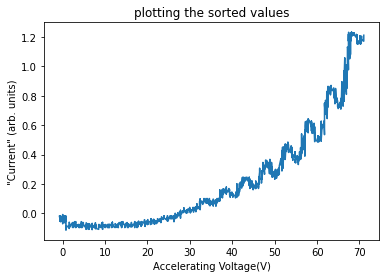

In [6]:
ind = np.argsort(channel1) # ind is an array containing the indices that would sort channel 1

ch1sorted = channel1[ind] # we index channel1 and channel2 with "ind" which sorts channel1 and make sure values in channel2 correspond to the new channel1 order
ch2sorted = channel2[ind]

plt.plot(ch1sorted, ch2sorted)
plt.xlabel('Accelerating Voltage(V)')
plt.ylabel('"Current" (arb. units)')
plt.title('plotting the sorted values')
# plt.xlim([20,40])

The code below shows how you could zoom in to see the peak locations more clearly.  The extra code is for making more tick marks so you could read the value off with more precision.

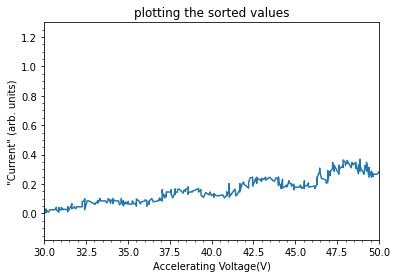

In [7]:
from matplotlib.ticker import AutoMinorLocator

ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(ch1sorted, ch2sorted)
plt.xlabel('Accelerating Voltage(V)')
plt.ylabel('"Current" (arb. units)')
plt.title('plotting the sorted values')
plt.xlim([30,50])  # this is how to "zoom" on the x-axis
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

### What next?
At this point you need to think about how to determine the spacing between peaks (or troughs...) and compare these to spacings you see for other parameters (e.g. different retarding voltages, different temperatures)

There are many ways to find peak distances.  One is to look at the peaks "by eye" and estimate.  For that method, you'll want to "zoom in" on the graph (you could use plt.xlim) and add more tick marks so you have enough precision.  This is what is done in the code block above.

Another way to determine the spacing might be to fit a Gaussian to your peaks (or troughs).   If you want to do that, please see the intro python notebook for how to define and fit a Gaussian.   

**The most important thing is that you have some estimate of the uncertainty involved in determining this spacing, and try to understand the trends you are seeing as a function of temperature or retarding voltage.  Have fun!**

## v3 -- A possible way to automate finding the distance between peaks
 
Finding all the peaks manually (by zooming or doing Gaussian fits) can be pretty time-consuming.  You may be wondering if there is a faster way.  **There is, thanks to the power of python!**
 
The method described here makes full use of the fact that you're doing this in a programming language with lots of slick options for data analysis.  It does require a bit of extra "coding", but if you're not scared by a few extra lines of code, read on.  

Below is one possible method to automate the peak finding. It uses a smoothing algorithm to reduce the noise in the data, and then a "peak finding" algorithm on the smoothed data.

You have to be careful not to believe every peak it automatically gives you - you'll see below it gives a lot of peaks in the low voltage region.  Those are not "real", i.e not the peaks you're looking for, but rather are remnants of noise.  When you use the peak positions for calculations, you want to exclude those fake ones. 

An essential practice whenever automating something like this is to check it is doing reasonable things for multiple datasets before trusting it.  In this case, you can check visually using a graph where the peaks are displayed.  

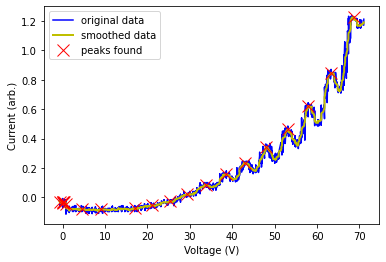

In [8]:
from scipy.signal import savgol_filter  # for smoothing function 
import scipy.signal as sig # for find peaks

ch2smoothed = savgol_filter(ch2sorted, 51, 4) # window size 51, polynomial order 3
[peakind,otherstuff] = sig.find_peaks(ch2smoothed,distance=80) # peakind is a list of indices where there are peaks in ch2smoothed

plt.plot(ch1sorted,ch2sorted,'b')
plt.plot(ch1sorted,ch2smoothed,'y',linewidth=2)  
plt.plot(ch1sorted[peakind],ch2smoothed[peakind],'rx',markersize=12)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (arb.)')
plt.legend(['original data','smoothed data','peaks found'])

Now you can use the peaks it found to do things like take differences and average them.

First let's take a look at what voltages it found peaks at.   I'm going to use the numpy "[where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)" command to exclude peaks below 30V since they don't seem to be the real peaks we're looking for.

In [9]:
cutoff = 30
peakind_cut = np.where(ch1sorted[peakind]>cutoff)[0]  
peaklist = ch1sorted[peakind][peakind_cut]  # the final list of peak voltages



Now we can find the peak distances and average them, and find their standard deviation.

In [15]:
differences = np.diff(peaklist) # diff takes the difference between each near-neighbor pair of points

dbest = np.mean(differences)
deltad = np.std(differences,ddof=1)

print('average peak spacing is ',np.round(dbest,1),' +/- ', np.round(deltad,1), ' V ')

average peak spacing is  5.0  +/-  0.4  V 
